# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import prune
from torch.amp import autocast, GradScaler
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision
from torchvision.datasets import ImageNet, CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms._presets import ImageClassification

from pathlib import Path
from tqdm.notebook import tqdm
from einops import einsum, rearrange, reduce
from typing import Union, Tuple, Any, Generator

import copy

Automatically detect cuda if available.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Fetch the Resnet18 weights trained from the ImageNet1000 images together with the needed image preprocessing.

In [3]:
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

The Resnet18 Architecture composed of multiple blocks where each block has residual connections.

In [4]:
model = resnet18(weights=weights)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Visualization of the different weights and biases shapes.

In [5]:
for layer_i, param in enumerate(model.parameters()):
    print('Layer', layer_i, 'shape: \n', param.shape,  '\n')

Layer 0 shape: 
 torch.Size([64, 3, 7, 7]) 

Layer 1 shape: 
 torch.Size([64]) 

Layer 2 shape: 
 torch.Size([64]) 

Layer 3 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 4 shape: 
 torch.Size([64]) 

Layer 5 shape: 
 torch.Size([64]) 

Layer 6 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 7 shape: 
 torch.Size([64]) 

Layer 8 shape: 
 torch.Size([64]) 

Layer 9 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 10 shape: 
 torch.Size([64]) 

Layer 11 shape: 
 torch.Size([64]) 

Layer 12 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 13 shape: 
 torch.Size([64]) 

Layer 14 shape: 
 torch.Size([64]) 

Layer 15 shape: 
 torch.Size([128, 64, 3, 3]) 

Layer 16 shape: 
 torch.Size([128]) 

Layer 17 shape: 
 torch.Size([128]) 

Layer 18 shape: 
 torch.Size([128, 128, 3, 3]) 

Layer 19 shape: 
 torch.Size([128]) 

Layer 20 shape: 
 torch.Size([128]) 

Layer 21 shape: 
 torch.Size([128, 64, 1, 1]) 

Layer 22 shape: 
 torch.Size([128]) 

Layer 23 shape: 
 torch.Size([128]) 

Layer 24 shape: 
 torch.Size([128

Create a dataset and dataloader object for the CIFAR10 dataset.

In [6]:
BATCH_SIZE = 512

try:
    from google.colab import drive
    drive.mount('/content/drive')
    datapath = Path().cwd() / 'drive' / 'MyDrive' / 'data'
except:
    datapath = Path().cwd() / 'data'
finally:
    print(f'Data from {datapath}')

cifar10 = CIFAR10(
    root=datapath,
    train=True,
    transform=transforms,
    download=True
)


cifar10_test = CIFAR10(
    root=datapath,
    train=False,
    transform=transforms,
    download=True
)

# cifar10 = torch.utils.data.Subset(cifar10, range(10))
# cifar10_test = torch.utils.data.Subset(cifar10_test, range(10))

dataloader = torch.utils.data.DataLoader(
    cifar10,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Data from /kaggle/working/data


The int to string mapping of the CIFAR10 labels.

In [7]:
label_mapping = dict(enumerate(cifar10.classes))
label_mapping

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [8]:
def visualize_normalized_image(image: torch.Tensor,
                               transform: ImageClassification,
                               batch_size: int) -> None:
    """
    Combines a batch of images into 1 and plots them.
    """
    assert isinstance(image, torch.Tensor), f'image type is {type(image)}'
    assert batch_size % 2 == 0, f'uneven {batch_size}'

    image = image.numpy()
    std, mean = transform.std, transform.mean
    std, mean = np.array(std), np.array(mean)

    b1, b2 = batch_size//8, 8
    image = einsum(image, std, 'b c h w, c -> b h w c') + mean
    image = rearrange(image, '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=b1, b2=b2)
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print('Shape: ', image.shape)

In [9]:
# n_of_batch_images_to_show = 4
# current_label = None

# for i, (image, label) in enumerate(dataloader):
#     label0 = int(label[0])

#     if label0 != current_label:
#         visualize_normalized_image(image, transforms, 32)
#         n_of_batch_images_to_show -= 1
#         current_label = label0

#     if n_of_batch_images_to_show == 0:
#         break


A storage object for the model loss and accuracy for both train and validation.

In [10]:
class ValTrainStorage:

    def __init__(self, name):
        self.name = name
        self.storage = {
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': []
        }

    def store(self, metrics):
        assert len(metrics) == 4, f'Expecting len = 4, got {len(metrics)}'
        self.storage['train_loss'].append(metrics[0])
        self.storage['val_loss'].append(metrics[1])
        self.storage['train_accuracy'].append(metrics[2])
        self.storage['val_accuracy'].append(metrics[3])

In [11]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.

    with torch.no_grad():
        for images, labels in tqdm(dataloader_test):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(dataloader)

    return accuracy, avg_loss


def train_model(model, dataloader, dataloader_test, device, num_epochs=20, storage=None):
    criterion = nn.CrossEntropyLoss().to(device)
    # optimizer = Adam(model.parameters(), lr=0.001)
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
    scaler = torch.amp.GradScaler('cuda')
    model = model.to(device)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_total_correct = 0
        train_total_samples = 0
        total_loss = 0.

        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            # optimizer.step()

            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total_samples += labels.size(0)
            train_total_correct += (predicted == labels).sum().item()


        train_accuracy = train_total_correct / train_total_samples
        train_avg_loss = total_loss / len(dataloader)
        val_accuracy, val_avg_loss = evaluate_model(model, dataloader_test, criterion, device)          
        scheduler.step()

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], learning_rate = {optimizer.param_groups[0]['lr']}",
            f'\nTrain Loss: {train_avg_loss}, Train Accuracy: {train_accuracy}',
            f'\nVal Loss: {val_avg_loss}, Val Accuracy: {val_accuracy}'
        )

        metrics = [train_avg_loss, val_avg_loss, train_accuracy, val_accuracy]
        storage.store(metrics)

A simple CNN model that will serve as the baseline for the performance of the depth pruned Resnet18.

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Convolutional feature extractor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128 * 28 * 28, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x

In [13]:
model_baseline = SimpleCNN()
storage_baseline = ValTrainStorage('baseline')
train_model(model_baseline, dataloader, dataloader_test, device, num_epochs=20, storage=storage_baseline)
torch.save(model_baseline, f"model_baseline.pt")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], learning_rate = 0.000994459753267812 
Train Loss: 2.010281178416038, Train Accuracy: 0.29002 
Val Loss: 1.8279608130455016, Val Accuracy: 0.3686


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20], learning_rate = 0.000977975432332819 
Train Loss: 1.7685730493798548, Train Accuracy: 0.38394 
Val Loss: 1.7066973745822906, Val Accuracy: 0.405


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20], learning_rate = 0.0009509529358847653 
Train Loss: 1.6807698510131057, Train Accuracy: 0.41552 
Val Loss: 1.6384137511253356, Val Accuracy: 0.4258


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20], learning_rate = 0.0009140576474687262 
Train Loss: 1.6180116959980555, Train Accuracy: 0.4373 
Val Loss: 1.596444296836853, Val Accuracy: 0.435


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], learning_rate = 0.0008681980515339462 
Train Loss: 1.5731339101888695, Train Accuracy: 0.45134 
Val Loss: 1.5598845541477204, Val Accuracy: 0.446


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20], learning_rate = 0.0008145033635316127 
Train Loss: 1.5364620673413178, Train Accuracy: 0.46562 
Val Loss: 1.5248209178447723, Val Accuracy: 0.4618


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20], learning_rate = 0.0007542957248827959 
Train Loss: 1.4967255981601015, Train Accuracy: 0.47854 
Val Loss: 1.500673919916153, Val Accuracy: 0.4791


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20], learning_rate = 0.0006890576474687263 
Train Loss: 1.4532623947883139, Train Accuracy: 0.49332 
Val Loss: 1.4467731773853303, Val Accuracy: 0.4874


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20], learning_rate = 0.0006203955092681039 
Train Loss: 1.4079007591520036, Train Accuracy: 0.50824 
Val Loss: 1.423905611038208, Val Accuracy: 0.495


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20], learning_rate = 0.0005499999999999999 
Train Loss: 1.3569348466639617, Train Accuracy: 0.52488 
Val Loss: 1.370756983757019, Val Accuracy: 0.5162


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20], learning_rate = 0.00047960449073189616 
Train Loss: 1.3215778579517288, Train Accuracy: 0.53984 
Val Loss: 1.3473146975040435, Val Accuracy: 0.5252


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20], learning_rate = 0.0004109423525312736 
Train Loss: 1.2851894424886119, Train Accuracy: 0.55142 
Val Loss: 1.3185607731342315, Val Accuracy: 0.5349


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20], learning_rate = 0.0003457042751172039 
Train Loss: 1.2557695471510595, Train Accuracy: 0.563 
Val Loss: 1.2996747195720673, Val Accuracy: 0.5403


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20], learning_rate = 0.0002854966364683871 
Train Loss: 1.2321167174650698, Train Accuracy: 0.5718 
Val Loss: 1.2849653601646422, Val Accuracy: 0.5451


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20], learning_rate = 0.00023180194846605365 
Train Loss: 1.2150564570816196, Train Accuracy: 0.57854 
Val Loss: 1.2695997953414917, Val Accuracy: 0.5536


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20], learning_rate = 0.0001859423525312737 
Train Loss: 1.1957667409157267, Train Accuracy: 0.58518 
Val Loss: 1.2614136815071106, Val Accuracy: 0.5596


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20], learning_rate = 0.0001490470641152345 
Train Loss: 1.184413503627388, Train Accuracy: 0.589 
Val Loss: 1.2572820723056792, Val Accuracy: 0.5574


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20], learning_rate = 0.00012202456766718092 
Train Loss: 1.172898107645463, Train Accuracy: 0.5931 
Val Loss: 1.2485527217388153, Val Accuracy: 0.5613


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20], learning_rate = 0.00010554024673218806 
Train Loss: 1.1654385085008583, Train Accuracy: 0.59782 
Val Loss: 1.2446593940258026, Val Accuracy: 0.5633


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20], learning_rate = 0.0001 
Train Loss: 1.1582423436398408, Train Accuracy: 0.59914 
Val Loss: 1.2499772250652312, Val Accuracy: 0.5609


In [14]:
total_params = sum(p.numel() for p in model_baseline.parameters())
trainable_params = sum(p.numel() for p in model_baseline.parameters() if p.requires_grad)
print('Total Parameters: ', total_params)
print('Trainable Parameters: ', trainable_params)

Total Parameters:  1096778
Trainable Parameters:  1096778


Iteratively pruning the resnet18 model block by block. Starting from changing the head or the 1st fully-connected layer to match the CIFAR10 dataset, then continue replacing each block with a sequential AdaptiveAvgPool2d, Flatten, and Linear layer until all the blocks with residual connections are removed. Note that only the head is trainable -- all other parameters are frozen as they are believed to already be trained to detect the features.

In [15]:
N_EPOCHS = 20
fc_out = len(label_mapping)
total_params_list = []
trainable_params_list = []
storage_list = []

layers = [
    'layer1.0',
    'layer1.1',
    'layer2.0',
    'layer2.1',
    'layer3.0',
    'layer3.1',
    'layer4.0',
    'layer4.1',
]

model_fc_in = model.fc.in_features
model_fc_out = len(label_mapping)
model.fc = nn.Linear(model_fc_in, model_fc_out)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
    
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params_list.append(total_params)
trainable_params_list.append(trainable_params)

storage = ValTrainStorage('head')
train_model(model, 
            dataloader, 
            dataloader_test,
            device,
            num_epochs=N_EPOCHS, 
            storage=storage)
storage_list.append(storage)
torch.save(model, 
           f"model_replaced_head.pt")

for i in range(len(layers), 0, -1):
    model_copy = copy.deepcopy(model)
    model_copy.avgpool = nn.Identity()
    model_copy.fc = nn.Identity()
    layers_to_prune = layers[i-1:]
    print()

    for j, layer in enumerate(layers_to_prune):
    
        if j == 0:
            non_identity_layer = layer
            new_layer = nn.Sequential(
                nn.AdaptiveAvgPool2d(
                    output_size=(1, 1)
                ),
                nn.Flatten()
            )
        else:
            new_layer = nn.Identity()
            
        print(f'Pruned {layer}')
        model_copy.set_submodule(layer, new_layer)

    fc_in = model_copy(torch.randn(1, 3, 224, 224).to(device)).shape[1]
    (model_copy
     .get_submodule(non_identity_layer)
     .append(nn.Linear(fc_in, fc_out)))

    for name, p in model_copy.named_parameters():
        if non_identity_layer in name:
            p.requires_grad = True
        else:
            p.requires_grad = False


    total_params = sum(p.numel() for p in model_copy.parameters())
    trainable_params = sum(p.numel() for p in model_copy.parameters() if p.requires_grad)
    total_params_list.append(total_params)
    trainable_params_list.append(trainable_params)

    storage = ValTrainStorage(non_identity_layer)
    train_model(model_copy, 
                dataloader, 
                dataloader_test,
                device,
                num_epochs=N_EPOCHS, 
                storage=storage)
    storage_list.append(storage)
    torch.save(model_copy, f"model_replaced_{non_identity_layer}.pt")
    

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], learning_rate = 0.000994459753267812 
Train Loss: 1.8428072223857956, Train Accuracy: 0.41098 
Val Loss: 1.3694880485534668, Val Accuracy: 0.6152


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20], learning_rate = 0.000977975432332819 
Train Loss: 1.1982184344408464, Train Accuracy: 0.66546 
Val Loss: 1.0802265673875808, Val Accuracy: 0.6829


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20], learning_rate = 0.0009509529358847653 
Train Loss: 1.0116411782040888, Train Accuracy: 0.70336 
Val Loss: 0.9624904721975327, Val Accuracy: 0.7033


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20], learning_rate = 0.0009140576474687262 
Train Loss: 0.9220679809852522, Train Accuracy: 0.71956 
Val Loss: 0.8988365858793259, Val Accuracy: 0.717


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], learning_rate = 0.0008681980515339462 
Train Loss: 0.8694117349021289, Train Accuracy: 0.72992 
Val Loss: 0.85751573741436, Val Accuracy: 0.7289


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20], learning_rate = 0.0008145033635316127 
Train Loss: 0.8330593419318296, Train Accuracy: 0.73652 
Val Loss: 0.8263953357934952, Val Accuracy: 0.7348


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20], learning_rate = 0.0007542957248827959 
Train Loss: 0.8087294782911029, Train Accuracy: 0.74184 
Val Loss: 0.8086790412664413, Val Accuracy: 0.7394


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20], learning_rate = 0.0006890576474687263 
Train Loss: 0.7900823938603304, Train Accuracy: 0.74714 
Val Loss: 0.7918655186891556, Val Accuracy: 0.7407


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20], learning_rate = 0.0006203955092681039 
Train Loss: 0.7760185161415412, Train Accuracy: 0.74858 
Val Loss: 0.7794401437044144, Val Accuracy: 0.7454


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20], learning_rate = 0.0005499999999999999 
Train Loss: 0.7634007024521731, Train Accuracy: 0.75208 
Val Loss: 0.7711294293403625, Val Accuracy: 0.7471


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20], learning_rate = 0.00047960449073189616 
Train Loss: 0.7547853759356907, Train Accuracy: 0.75358 
Val Loss: 0.7632448464632035, Val Accuracy: 0.7507


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20], learning_rate = 0.0004109423525312736 
Train Loss: 0.7473223337105342, Train Accuracy: 0.75634 
Val Loss: 0.7575888186693192, Val Accuracy: 0.7524


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20], learning_rate = 0.0003457042751172039 
Train Loss: 0.7419414349964687, Train Accuracy: 0.75698 
Val Loss: 0.7522811532020569, Val Accuracy: 0.7529


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20], learning_rate = 0.0002854966364683871 
Train Loss: 0.7369394247629204, Train Accuracy: 0.75788 
Val Loss: 0.7481360167264939, Val Accuracy: 0.7563


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20], learning_rate = 0.00023180194846605365 
Train Loss: 0.7323368714780224, Train Accuracy: 0.75874 
Val Loss: 0.7451119095087051, Val Accuracy: 0.7563


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20], learning_rate = 0.0001859423525312737 
Train Loss: 0.73016684091821, Train Accuracy: 0.75928 
Val Loss: 0.7423541098833084, Val Accuracy: 0.7565


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20], learning_rate = 0.0001490470641152345 
Train Loss: 0.7288351466461104, Train Accuracy: 0.7589 
Val Loss: 0.7414283931255341, Val Accuracy: 0.7573


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20], learning_rate = 0.00012202456766718092 
Train Loss: 0.7265266587539595, Train Accuracy: 0.7596 
Val Loss: 0.7397268712520599, Val Accuracy: 0.7577


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20], learning_rate = 0.00010554024673218806 
Train Loss: 0.7250469089770804, Train Accuracy: 0.76068 
Val Loss: 0.7395429611206055, Val Accuracy: 0.7573


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20], learning_rate = 0.0001 
Train Loss: 0.7248122272442798, Train Accuracy: 0.7609 
Val Loss: 0.7373445123434067, Val Accuracy: 0.7587

Pruned layer4.1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], learning_rate = 0.000994459753267812 
Train Loss: 2.3007645850278893, Train Accuracy: 0.11708 
Val Loss: 2.292291724681854, Val Accuracy: 0.1619


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20], learning_rate = 0.000977975432332819 
Train Loss: 2.2849350559468173, Train Accuracy: 0.2218 
Val Loss: 2.2765201687812806, Val Accuracy: 0.2863


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20], learning_rate = 0.0009509529358847653 
Train Loss: 2.2696250068898105, Train Accuracy: 0.32382 
Val Loss: 2.261470091342926, Val Accuracy: 0.3649


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20], learning_rate = 0.0009140576474687262 
Train Loss: 2.2549980684202544, Train Accuracy: 0.38776 
Val Loss: 2.2472894191741943, Val Accuracy: 0.4093


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], learning_rate = 0.0008681980515339462 
Train Loss: 2.2411178715375004, Train Accuracy: 0.42566 
Val Loss: 2.2339046120643617, Val Accuracy: 0.4404


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20], learning_rate = 0.0008145033635316127 
Train Loss: 2.2281103182812125, Train Accuracy: 0.45486 
Val Loss: 2.221021592617035, Val Accuracy: 0.4637


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20], learning_rate = 0.0007542957248827959 
Train Loss: 2.2159783767194163, Train Accuracy: 0.4715 
Val Loss: 2.2092584490776064, Val Accuracy: 0.4778


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20], learning_rate = 0.0006890576474687263 
Train Loss: 2.2048329698796176, Train Accuracy: 0.49014 
Val Loss: 2.198795998096466, Val Accuracy: 0.4936


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20], learning_rate = 0.0006203955092681039 
Train Loss: 2.194754814615055, Train Accuracy: 0.50148 
Val Loss: 2.188991665840149, Val Accuracy: 0.5013


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20], learning_rate = 0.0005499999999999999 
Train Loss: 2.185662722101017, Train Accuracy: 0.51104 
Val Loss: 2.180436110496521, Val Accuracy: 0.5088


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20], learning_rate = 0.00047960449073189616 
Train Loss: 2.177609088469525, Train Accuracy: 0.51964 
Val Loss: 2.1729612708091737, Val Accuracy: 0.5197


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20], learning_rate = 0.0004109423525312736 
Train Loss: 2.1706277788901818, Train Accuracy: 0.52586 
Val Loss: 2.166359543800354, Val Accuracy: 0.5236


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20], learning_rate = 0.0003457042751172039 
Train Loss: 2.1647044322928606, Train Accuracy: 0.5308 
Val Loss: 2.1610103845596313, Val Accuracy: 0.5276


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20], learning_rate = 0.0002854966364683871 
Train Loss: 2.1596055079479606, Train Accuracy: 0.53396 
Val Loss: 2.156364953517914, Val Accuracy: 0.5309


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20], learning_rate = 0.00023180194846605365 
Train Loss: 2.1553288284613163, Train Accuracy: 0.53642 
Val Loss: 2.152535057067871, Val Accuracy: 0.5344


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20], learning_rate = 0.0001859423525312737 
Train Loss: 2.151980536324637, Train Accuracy: 0.53828 
Val Loss: 2.149643290042877, Val Accuracy: 0.5361


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20], learning_rate = 0.0001490470641152345 
Train Loss: 2.149251023117377, Train Accuracy: 0.54076 
Val Loss: 2.1467965722084044, Val Accuracy: 0.537


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20], learning_rate = 0.00012202456766718092 
Train Loss: 2.1470420287579906, Train Accuracy: 0.54114 
Val Loss: 2.1449482321739195, Val Accuracy: 0.5391


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20], learning_rate = 0.00010554024673218806 
Train Loss: 2.1453029087611606, Train Accuracy: 0.5428 
Val Loss: 2.1434638857841493, Val Accuracy: 0.5397


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20], learning_rate = 0.0001 
Train Loss: 2.1437186464971427, Train Accuracy: 0.54364 
Val Loss: 2.142116391658783, Val Accuracy: 0.5424

Pruned layer4.0
Pruned layer4.1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], learning_rate = 0.000994459753267812 
Train Loss: 2.3035247544853057, Train Accuracy: 0.0942 
Val Loss: 2.2981248021125795, Val Accuracy: 0.1041


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20], learning_rate = 0.000977975432332819 
Train Loss: 2.2941568141080895, Train Accuracy: 0.12338 
Val Loss: 2.289537024497986, Val Accuracy: 0.156


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20], learning_rate = 0.0009509529358847653 
Train Loss: 2.2860228309825974, Train Accuracy: 0.1852 
Val Loss: 2.2816471576690676, Val Accuracy: 0.2246


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20], learning_rate = 0.0009140576474687262 
Train Loss: 2.2784538512327233, Train Accuracy: 0.24712 
Val Loss: 2.274363648891449, Val Accuracy: 0.2683


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], learning_rate = 0.0008681980515339462 
Train Loss: 2.2713327943062294, Train Accuracy: 0.28204 
Val Loss: 2.2673899054527284, Val Accuracy: 0.3033


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20], learning_rate = 0.0008145033635316127 
Train Loss: 2.26465342482742, Train Accuracy: 0.31028 
Val Loss: 2.2608607411384583, Val Accuracy: 0.3263


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20], learning_rate = 0.0007542957248827959 
Train Loss: 2.2583853809200987, Train Accuracy: 0.32946 
Val Loss: 2.254787766933441, Val Accuracy: 0.3419


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20], learning_rate = 0.0006890576474687263 
Train Loss: 2.252611600622839, Train Accuracy: 0.3417 
Val Loss: 2.2492444634437563, Val Accuracy: 0.3559


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20], learning_rate = 0.0006203955092681039 
Train Loss: 2.2473550086118737, Train Accuracy: 0.3575 
Val Loss: 2.2441723465919496, Val Accuracy: 0.3693


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20], learning_rate = 0.0005499999999999999 
Train Loss: 2.2425858706844095, Train Accuracy: 0.36834 
Val Loss: 2.239621126651764, Val Accuracy: 0.3784


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20], learning_rate = 0.00047960449073189616 
Train Loss: 2.2383983840747756, Train Accuracy: 0.3745 
Val Loss: 2.2357273936271667, Val Accuracy: 0.3864


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20], learning_rate = 0.0004109423525312736 
Train Loss: 2.2347072873796736, Train Accuracy: 0.38032 
Val Loss: 2.2321910858154297, Val Accuracy: 0.3902


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20], learning_rate = 0.0003457042751172039 
Train Loss: 2.231521971371709, Train Accuracy: 0.38636 
Val Loss: 2.2294183373451233, Val Accuracy: 0.3928


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20], learning_rate = 0.0002854966364683871 
Train Loss: 2.2288456011791618, Train Accuracy: 0.38936 
Val Loss: 2.2268038272857664, Val Accuracy: 0.3965


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20], learning_rate = 0.00023180194846605365 
Train Loss: 2.2265875923390293, Train Accuracy: 0.39262 
Val Loss: 2.224821376800537, Val Accuracy: 0.4023


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20], learning_rate = 0.0001859423525312737 
Train Loss: 2.224809169769287, Train Accuracy: 0.39614 
Val Loss: 2.2231560230255125, Val Accuracy: 0.4039


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20], learning_rate = 0.0001490470641152345 
Train Loss: 2.223352128145646, Train Accuracy: 0.39702 
Val Loss: 2.221787858009338, Val Accuracy: 0.4034


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20], learning_rate = 0.00012202456766718092 
Train Loss: 2.2221342982078087, Train Accuracy: 0.39888 
Val Loss: 2.220900809764862, Val Accuracy: 0.4047


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20], learning_rate = 0.00010554024673218806 
Train Loss: 2.221219245268374, Train Accuracy: 0.4003 
Val Loss: 2.220014715194702, Val Accuracy: 0.4054


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20], learning_rate = 0.0001 
Train Loss: 2.2203742314358146, Train Accuracy: 0.40202 
Val Loss: 2.219267117977142, Val Accuracy: 0.4079

Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], learning_rate = 0.000994459753267812 
Train Loss: 2.308931533171206, Train Accuracy: 0.11978 
Val Loss: 2.302070713043213, Val Accuracy: 0.1382


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20], learning_rate = 0.000977975432332819 
Train Loss: 2.297131823033703, Train Accuracy: 0.1541 
Val Loss: 2.2905212521553038, Val Accuracy: 0.1766


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20], learning_rate = 0.0009509529358847653 
Train Loss: 2.286018687851575, Train Accuracy: 0.1975 
Val Loss: 2.2795836448669435, Val Accuracy: 0.2278


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20], learning_rate = 0.0009140576474687262 
Train Loss: 2.2754584721156528, Train Accuracy: 0.24692 
Val Loss: 2.2692573428153993, Val Accuracy: 0.272


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], learning_rate = 0.0008681980515339462 
Train Loss: 2.2655135904039656, Train Accuracy: 0.28262 
Val Loss: 2.2593570351600647, Val Accuracy: 0.3015


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20], learning_rate = 0.0008145033635316127 
Train Loss: 2.256193353205311, Train Accuracy: 0.31114 
Val Loss: 2.2504188776016236, Val Accuracy: 0.3202


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20], learning_rate = 0.0007542957248827959 
Train Loss: 2.2475053728843224, Train Accuracy: 0.32556 
Val Loss: 2.241944146156311, Val Accuracy: 0.3355


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20], learning_rate = 0.0006890576474687263 
Train Loss: 2.239581344078998, Train Accuracy: 0.33882 
Val Loss: 2.234328591823578, Val Accuracy: 0.3455


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20], learning_rate = 0.0006203955092681039 
Train Loss: 2.2323416252525483, Train Accuracy: 0.34696 
Val Loss: 2.2275134325027466, Val Accuracy: 0.3546


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20], learning_rate = 0.0005499999999999999 
Train Loss: 2.2258986380635477, Train Accuracy: 0.35326 
Val Loss: 2.22150696516037, Val Accuracy: 0.3549


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20], learning_rate = 0.00047960449073189616 
Train Loss: 2.2201607130011736, Train Accuracy: 0.3595 
Val Loss: 2.215916430950165, Val Accuracy: 0.3644


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20], learning_rate = 0.0004109423525312736 
Train Loss: 2.2151680941484413, Train Accuracy: 0.36482 
Val Loss: 2.2114391326904297, Val Accuracy: 0.3682


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20], learning_rate = 0.0003457042751172039 
Train Loss: 2.2110045223819967, Train Accuracy: 0.3673 
Val Loss: 2.2073296308517456, Val Accuracy: 0.3702


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20], learning_rate = 0.0002854966364683871 
Train Loss: 2.2073237847308724, Train Accuracy: 0.37102 
Val Loss: 2.2042372465133666, Val Accuracy: 0.3749


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20], learning_rate = 0.00023180194846605365 
Train Loss: 2.204458059096823, Train Accuracy: 0.3729 
Val Loss: 2.2013285994529723, Val Accuracy: 0.3776


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20], learning_rate = 0.0001859423525312737 
Train Loss: 2.2019751120586784, Train Accuracy: 0.37352 
Val Loss: 2.1992297887802126, Val Accuracy: 0.3761


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20], learning_rate = 0.0001490470641152345 
Train Loss: 2.200031930086564, Train Accuracy: 0.37564 
Val Loss: 2.197558104991913, Val Accuracy: 0.3786


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20], learning_rate = 0.00012202456766718092 
Train Loss: 2.1984418679256827, Train Accuracy: 0.3778 
Val Loss: 2.1962321758270265, Val Accuracy: 0.3802


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20], learning_rate = 0.00010554024673218806 
Train Loss: 2.1972306747825776, Train Accuracy: 0.37722 
Val Loss: 2.1950275540351867, Val Accuracy: 0.3811


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20], learning_rate = 0.0001 
Train Loss: 2.1961727190990836, Train Accuracy: 0.3785 
Val Loss: 2.194095480442047, Val Accuracy: 0.3803

Pruned layer3.0
Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], learning_rate = 0.000994459753267812 
Train Loss: 2.301220183469811, Train Accuracy: 0.12394 
Val Loss: 2.2969079494476317, Val Accuracy: 0.132


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20], learning_rate = 0.000977975432332819 
Train Loss: 2.2936020335372613, Train Accuracy: 0.15008 
Val Loss: 2.29038645029068, Val Accuracy: 0.1604


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20], learning_rate = 0.0009509529358847653 
Train Loss: 2.2877429188514244, Train Accuracy: 0.17674 
Val Loss: 2.2848957777023315, Val Accuracy: 0.1905


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20], learning_rate = 0.0009140576474687262 
Train Loss: 2.2825415377714195, Train Accuracy: 0.201 
Val Loss: 2.279927372932434, Val Accuracy: 0.2185


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], learning_rate = 0.0008681980515339462 
Train Loss: 2.2777339633630245, Train Accuracy: 0.2379 
Val Loss: 2.275092053413391, Val Accuracy: 0.2407


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20], learning_rate = 0.0008145033635316127 
Train Loss: 2.273188357450524, Train Accuracy: 0.24766 
Val Loss: 2.270689821243286, Val Accuracy: 0.2578


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20], learning_rate = 0.0007542957248827959 
Train Loss: 2.2689835976581185, Train Accuracy: 0.26794 
Val Loss: 2.2665927052497863, Val Accuracy: 0.2688


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20], learning_rate = 0.0006890576474687263 
Train Loss: 2.2650796369630464, Train Accuracy: 0.27706 
Val Loss: 2.262788736820221, Val Accuracy: 0.2824


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20], learning_rate = 0.0006203955092681039 
Train Loss: 2.261486768722534, Train Accuracy: 0.28572 
Val Loss: 2.2593878149986266, Val Accuracy: 0.2942


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20], learning_rate = 0.0005499999999999999 
Train Loss: 2.2583156556499246, Train Accuracy: 0.2938 
Val Loss: 2.256342649459839, Val Accuracy: 0.2995


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20], learning_rate = 0.00047960449073189616 
Train Loss: 2.2554927845390473, Train Accuracy: 0.2992 
Val Loss: 2.25363142490387, Val Accuracy: 0.3012


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20], learning_rate = 0.0004109423525312736 
Train Loss: 2.252986494375735, Train Accuracy: 0.30418 
Val Loss: 2.251257598400116, Val Accuracy: 0.3109


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20], learning_rate = 0.0003457042751172039 
Train Loss: 2.2508301564625333, Train Accuracy: 0.30864 
Val Loss: 2.249279522895813, Val Accuracy: 0.3146


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20], learning_rate = 0.0002854966364683871 
Train Loss: 2.249024447129697, Train Accuracy: 0.31344 
Val Loss: 2.247617042064667, Val Accuracy: 0.3168


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20], learning_rate = 0.00023180194846605365 
Train Loss: 2.2475532439290262, Train Accuracy: 0.31622 
Val Loss: 2.246291220188141, Val Accuracy: 0.319


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20], learning_rate = 0.0001859423525312737 
Train Loss: 2.2462572151300857, Train Accuracy: 0.31732 
Val Loss: 2.245098292827606, Val Accuracy: 0.321


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20], learning_rate = 0.0001490470641152345 
Train Loss: 2.2452760350947476, Train Accuracy: 0.31878 
Val Loss: 2.2442970752716063, Val Accuracy: 0.3206


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20], learning_rate = 0.00012202456766718092 
Train Loss: 2.2444610620031553, Train Accuracy: 0.32014 
Val Loss: 2.2434737920761108, Val Accuracy: 0.3217


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20], learning_rate = 0.00010554024673218806 
Train Loss: 2.2438962362250505, Train Accuracy: 0.3212 
Val Loss: 2.242989206314087, Val Accuracy: 0.3234


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20], learning_rate = 0.0001 
Train Loss: 2.2433532087170347, Train Accuracy: 0.32134 
Val Loss: 2.2424116253852846, Val Accuracy: 0.3236

Pruned layer2.1
Pruned layer3.0
Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], learning_rate = 0.000994459753267812 
Train Loss: 2.3028035115222543, Train Accuracy: 0.1131 
Val Loss: 2.29705970287323, Val Accuracy: 0.1273


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20], learning_rate = 0.000977975432332819 
Train Loss: 2.292140826887014, Train Accuracy: 0.14644 
Val Loss: 2.287593412399292, Val Accuracy: 0.1566


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20], learning_rate = 0.0009509529358847653 
Train Loss: 2.2835088165438906, Train Accuracy: 0.17768 
Val Loss: 2.2794327259063722, Val Accuracy: 0.198


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20], learning_rate = 0.0009140576474687262 
Train Loss: 2.2758361976973864, Train Accuracy: 0.23138 
Val Loss: 2.2719757914543153, Val Accuracy: 0.2534


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], learning_rate = 0.0008681980515339462 
Train Loss: 2.268674388223765, Train Accuracy: 0.26516 
Val Loss: 2.265003478527069, Val Accuracy: 0.2816


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20], learning_rate = 0.0008145033635316127 
Train Loss: 2.262073275994281, Train Accuracy: 0.29016 
Val Loss: 2.2585192561149596, Val Accuracy: 0.2884


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20], learning_rate = 0.0007542957248827959 
Train Loss: 2.255946711618073, Train Accuracy: 0.30274 
Val Loss: 2.2525549650192263, Val Accuracy: 0.2978


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20], learning_rate = 0.0006890576474687263 
Train Loss: 2.250254976506136, Train Accuracy: 0.31008 
Val Loss: 2.2471689939498902, Val Accuracy: 0.3051


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20], learning_rate = 0.0006203955092681039 
Train Loss: 2.245163971064042, Train Accuracy: 0.31444 
Val Loss: 2.242352294921875, Val Accuracy: 0.3109


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20], learning_rate = 0.0005499999999999999 
Train Loss: 2.2406343659576105, Train Accuracy: 0.31842 
Val Loss: 2.237970197200775, Val Accuracy: 0.3115


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20], learning_rate = 0.00047960449073189616 
Train Loss: 2.236552902630397, Train Accuracy: 0.31936 
Val Loss: 2.23410849571228, Val Accuracy: 0.3153


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20], learning_rate = 0.0004109423525312736 
Train Loss: 2.233098025224647, Train Accuracy: 0.32238 
Val Loss: 2.230832517147064, Val Accuracy: 0.3169


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20], learning_rate = 0.0003457042751172039 
Train Loss: 2.2300714473335113, Train Accuracy: 0.3237 
Val Loss: 2.2279804825782774, Val Accuracy: 0.3209


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20], learning_rate = 0.0002854966364683871 
Train Loss: 2.2275347758312614, Train Accuracy: 0.3253 
Val Loss: 2.225637400150299, Val Accuracy: 0.3193


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20], learning_rate = 0.00023180194846605365 
Train Loss: 2.2254319458591696, Train Accuracy: 0.3258 
Val Loss: 2.2238414168357847, Val Accuracy: 0.321


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20], learning_rate = 0.0001859423525312737 
Train Loss: 2.223677075639063, Train Accuracy: 0.32738 
Val Loss: 2.2222896575927735, Val Accuracy: 0.3204


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20], learning_rate = 0.0001490470641152345 
Train Loss: 2.222347802045394, Train Accuracy: 0.32714 
Val Loss: 2.2210078954696657, Val Accuracy: 0.3213


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20], learning_rate = 0.00012202456766718092 
Train Loss: 2.2212269208869158, Train Accuracy: 0.32818 
Val Loss: 2.2201411604881285, Val Accuracy: 0.3214


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20], learning_rate = 0.00010554024673218806 
Train Loss: 2.220296497247657, Train Accuracy: 0.32762 
Val Loss: 2.2191781640052795, Val Accuracy: 0.322


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20], learning_rate = 0.0001 
Train Loss: 2.2196221205652975, Train Accuracy: 0.32776 
Val Loss: 2.2184649467468263, Val Accuracy: 0.3219

Pruned layer2.0
Pruned layer2.1
Pruned layer3.0
Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], learning_rate = 0.000994459753267812 
Train Loss: 2.3105094554472942, Train Accuracy: 0.10574 
Val Loss: 2.2964480757713317, Val Accuracy: 0.1122


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20], learning_rate = 0.000977975432332819 
Train Loss: 2.292896197766674, Train Accuracy: 0.11812 
Val Loss: 2.289558136463165, Val Accuracy: 0.1351


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20], learning_rate = 0.0009509529358847653 
Train Loss: 2.287299414070285, Train Accuracy: 0.14396 
Val Loss: 2.284440004825592, Val Accuracy: 0.1429


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20], learning_rate = 0.0009140576474687262 
Train Loss: 2.2824057997489464, Train Accuracy: 0.15336 
Val Loss: 2.2795689940452575, Val Accuracy: 0.157


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], learning_rate = 0.0008681980515339462 
Train Loss: 2.277746300308072, Train Accuracy: 0.15958 
Val Loss: 2.274977946281433, Val Accuracy: 0.1694


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20], learning_rate = 0.0008145033635316127 
Train Loss: 2.273340823699017, Train Accuracy: 0.17504 
Val Loss: 2.2707833766937258, Val Accuracy: 0.1832


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20], learning_rate = 0.0007542957248827959 
Train Loss: 2.2692373163846074, Train Accuracy: 0.18944 
Val Loss: 2.2667296648025514, Val Accuracy: 0.1936


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20], learning_rate = 0.0006890576474687263 
Train Loss: 2.2654686095763226, Train Accuracy: 0.19576 
Val Loss: 2.263133692741394, Val Accuracy: 0.2021


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20], learning_rate = 0.0006203955092681039 
Train Loss: 2.262106318863071, Train Accuracy: 0.19812 
Val Loss: 2.259766721725464, Val Accuracy: 0.2067


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20], learning_rate = 0.0005499999999999999 
Train Loss: 2.2589753963509382, Train Accuracy: 0.21126 
Val Loss: 2.256774115562439, Val Accuracy: 0.2143


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20], learning_rate = 0.00047960449073189616 
Train Loss: 2.256327517178594, Train Accuracy: 0.21086 
Val Loss: 2.2543423652648924, Val Accuracy: 0.2159


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20], learning_rate = 0.0004109423525312736 
Train Loss: 2.253900613103594, Train Accuracy: 0.21572 
Val Loss: 2.25219064950943, Val Accuracy: 0.218


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20], learning_rate = 0.0003457042751172039 
Train Loss: 2.25186972958701, Train Accuracy: 0.21804 
Val Loss: 2.2501224875450134, Val Accuracy: 0.2179


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20], learning_rate = 0.0002854966364683871 
Train Loss: 2.250126449429259, Train Accuracy: 0.22024 
Val Loss: 2.248464071750641, Val Accuracy: 0.221


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20], learning_rate = 0.00023180194846605365 
Train Loss: 2.2487119265965054, Train Accuracy: 0.21976 
Val Loss: 2.2472460865974426, Val Accuracy: 0.22


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20], learning_rate = 0.0001859423525312737 
Train Loss: 2.2475695756016947, Train Accuracy: 0.22082 
Val Loss: 2.246119749546051, Val Accuracy: 0.2241


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20], learning_rate = 0.0001490470641152345 
Train Loss: 2.246618944771436, Train Accuracy: 0.2223 
Val Loss: 2.2454328656196596, Val Accuracy: 0.222


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20], learning_rate = 0.00012202456766718092 
Train Loss: 2.2458886200067947, Train Accuracy: 0.22292 
Val Loss: 2.244694542884827, Val Accuracy: 0.2246


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20], learning_rate = 0.00010554024673218806 
Train Loss: 2.2453041563228684, Train Accuracy: 0.22412 
Val Loss: 2.2441475629806518, Val Accuracy: 0.2251


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20], learning_rate = 0.0001 
Train Loss: 2.2447192741900075, Train Accuracy: 0.22412 
Val Loss: 2.2437933444976808, Val Accuracy: 0.2235

Pruned layer1.1
Pruned layer2.0
Pruned layer2.1
Pruned layer3.0
Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], learning_rate = 0.000994459753267812 
Train Loss: 2.310695514387014, Train Accuracy: 0.12068 
Val Loss: 2.300615072250366, Val Accuracy: 0.136


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20], learning_rate = 0.000977975432332819 
Train Loss: 2.294963014369108, Train Accuracy: 0.15196 
Val Loss: 2.2899487972259522, Val Accuracy: 0.1651


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20], learning_rate = 0.0009509529358847653 
Train Loss: 2.2858075827968363, Train Accuracy: 0.16474 
Val Loss: 2.2812929511070252, Val Accuracy: 0.1783


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20], learning_rate = 0.0009140576474687262 
Train Loss: 2.27764524489033, Train Accuracy: 0.17604 
Val Loss: 2.273009467124939, Val Accuracy: 0.1878


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], learning_rate = 0.0008681980515339462 
Train Loss: 2.2700693826286162, Train Accuracy: 0.19038 
Val Loss: 2.265492010116577, Val Accuracy: 0.1948


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20], learning_rate = 0.0008145033635316127 
Train Loss: 2.2630776775126553, Train Accuracy: 0.1923 
Val Loss: 2.258850169181824, Val Accuracy: 0.1963


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20], learning_rate = 0.0007542957248827959 
Train Loss: 2.2566844662841485, Train Accuracy: 0.19328 
Val Loss: 2.252494144439697, Val Accuracy: 0.1995


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20], learning_rate = 0.0006890576474687263 
Train Loss: 2.2508464346126633, Train Accuracy: 0.19686 
Val Loss: 2.2468914270401, Val Accuracy: 0.201


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20], learning_rate = 0.0006203955092681039 
Train Loss: 2.2456292862794838, Train Accuracy: 0.19732 
Val Loss: 2.241940128803253, Val Accuracy: 0.2084


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20], learning_rate = 0.0005499999999999999 
Train Loss: 2.241095479653806, Train Accuracy: 0.20416 
Val Loss: 2.237338054180145, Val Accuracy: 0.212


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20], learning_rate = 0.00047960449073189616 
Train Loss: 2.237030321237992, Train Accuracy: 0.20474 
Val Loss: 2.2335601925849913, Val Accuracy: 0.2107


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20], learning_rate = 0.0004109423525312736 
Train Loss: 2.233570166996547, Train Accuracy: 0.20604 
Val Loss: 2.230214846134186, Val Accuracy: 0.2165


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20], learning_rate = 0.0003457042751172039 
Train Loss: 2.230588119857165, Train Accuracy: 0.20822 
Val Loss: 2.2274067044258117, Val Accuracy: 0.2164


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20], learning_rate = 0.0002854966364683871 
Train Loss: 2.228004990791788, Train Accuracy: 0.2098 
Val Loss: 2.224915874004364, Val Accuracy: 0.2189


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20], learning_rate = 0.00023180194846605365 
Train Loss: 2.225978756437496, Train Accuracy: 0.20932 
Val Loss: 2.223105263710022, Val Accuracy: 0.2196


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20], learning_rate = 0.0001859423525312737 
Train Loss: 2.2242479567625084, Train Accuracy: 0.2112 
Val Loss: 2.2218670129776, Val Accuracy: 0.2208


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20], learning_rate = 0.0001490470641152345 
Train Loss: 2.222945427408024, Train Accuracy: 0.21154 
Val Loss: 2.2200460910797117, Val Accuracy: 0.2224


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20], learning_rate = 0.00012202456766718092 
Train Loss: 2.222000063682089, Train Accuracy: 0.21204 
Val Loss: 2.2192525267601013, Val Accuracy: 0.2217


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20], learning_rate = 0.00010554024673218806 
Train Loss: 2.2211398616129037, Train Accuracy: 0.21252 
Val Loss: 2.218896913528442, Val Accuracy: 0.2225


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20], learning_rate = 0.0001 
Train Loss: 2.220351800626638, Train Accuracy: 0.21286 
Val Loss: 2.2182388305664062, Val Accuracy: 0.222

Pruned layer1.0
Pruned layer1.1
Pruned layer2.0
Pruned layer2.1
Pruned layer3.0
Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], learning_rate = 0.000994459753267812 
Train Loss: 2.3108107897700094, Train Accuracy: 0.12606 
Val Loss: 2.2991883873939516, Val Accuracy: 0.1462


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20], learning_rate = 0.000977975432332819 
Train Loss: 2.2927370193053265, Train Accuracy: 0.16254 
Val Loss: 2.286206305027008, Val Accuracy: 0.1683


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20], learning_rate = 0.0009509529358847653 
Train Loss: 2.2820360392940287, Train Accuracy: 0.18226 
Val Loss: 2.2764039874076842, Val Accuracy: 0.1851


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20], learning_rate = 0.0009140576474687262 
Train Loss: 2.2732235047282003, Train Accuracy: 0.18964 
Val Loss: 2.2677188754081725, Val Accuracy: 0.1915


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], learning_rate = 0.0008681980515339462 
Train Loss: 2.2652501476054288, Train Accuracy: 0.19588 
Val Loss: 2.259935665130615, Val Accuracy: 0.1977


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20], learning_rate = 0.0008145033635316127 
Train Loss: 2.2580310836130257, Train Accuracy: 0.19762 
Val Loss: 2.2522701263427733, Val Accuracy: 0.2


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20], learning_rate = 0.0007542957248827959 
Train Loss: 2.251450769755305, Train Accuracy: 0.20456 
Val Loss: 2.246193754673004, Val Accuracy: 0.203


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20], learning_rate = 0.0006890576474687263 
Train Loss: 2.2456708246347854, Train Accuracy: 0.2073 
Val Loss: 2.2402417778968813, Val Accuracy: 0.2065


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20], learning_rate = 0.0006203955092681039 
Train Loss: 2.2404372546137594, Train Accuracy: 0.20844 
Val Loss: 2.2355197429656983, Val Accuracy: 0.2054


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20], learning_rate = 0.0005499999999999999 
Train Loss: 2.2359979541934267, Train Accuracy: 0.20884 
Val Loss: 2.230525541305542, Val Accuracy: 0.2097


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20], learning_rate = 0.00047960449073189616 
Train Loss: 2.232039534315771, Train Accuracy: 0.21224 
Val Loss: 2.22746205329895, Val Accuracy: 0.2122


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20], learning_rate = 0.0004109423525312736 
Train Loss: 2.228721487278841, Train Accuracy: 0.21318 
Val Loss: 2.2241819500923157, Val Accuracy: 0.2143


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20], learning_rate = 0.0003457042751172039 
Train Loss: 2.2258271976393096, Train Accuracy: 0.21382 
Val Loss: 2.2213621854782106, Val Accuracy: 0.2147


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20], learning_rate = 0.0002854966364683871 
Train Loss: 2.2235655298038406, Train Accuracy: 0.21386 
Val Loss: 2.2185877919197083, Val Accuracy: 0.2159


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20], learning_rate = 0.00023180194846605365 
Train Loss: 2.22162156932208, Train Accuracy: 0.21532 
Val Loss: 2.2175992369651794, Val Accuracy: 0.2171


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20], learning_rate = 0.0001859423525312737 
Train Loss: 2.2200090252623266, Train Accuracy: 0.21514 
Val Loss: 2.216283178329468, Val Accuracy: 0.2162


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20], learning_rate = 0.0001490470641152345 
Train Loss: 2.2187394147016564, Train Accuracy: 0.21608 
Val Loss: 2.2149905800819396, Val Accuracy: 0.2177


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20], learning_rate = 0.00012202456766718092 
Train Loss: 2.217818335610993, Train Accuracy: 0.21596 
Val Loss: 2.213268458843231, Val Accuracy: 0.2182


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20], learning_rate = 0.00010554024673218806 
Train Loss: 2.21700982171662, Train Accuracy: 0.21648 
Val Loss: 2.2137125372886657, Val Accuracy: 0.2185


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20], learning_rate = 0.0001 
Train Loss: 2.2163796741135267, Train Accuracy: 0.21678 
Val Loss: 2.211900055408478, Val Accuracy: 0.2185


[11181642, 6461002, 2785354, 1604682, 684362, 388938, 158154, 84170, 10186]


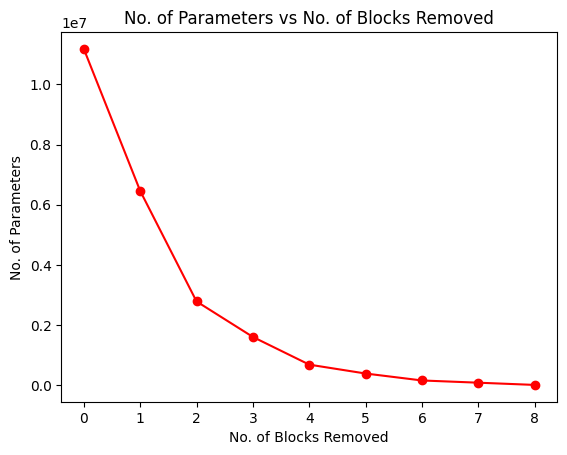

In [16]:
print(total_params_list)
plt.plot(total_params_list, 'r-o')
plt.xlabel('No. of Blocks Removed')
plt.ylabel('No. of Parameters')
plt.title('No. of Parameters vs No. of Blocks Removed')
plt.show();

[5130, 5130, 2570, 2570, 1290, 1290, 650, 650, 650]


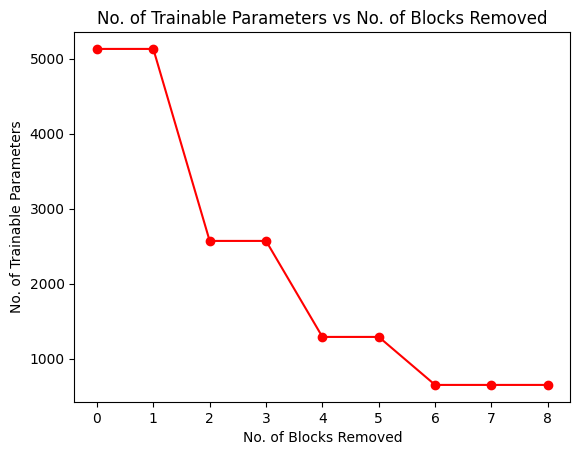

In [17]:
print(trainable_params_list)
plt.plot(trainable_params_list, 'r-o')
plt.xlabel('No. of Blocks Removed')
plt.ylabel('No. of Trainable Parameters')
plt.title('No. of Trainable Parameters vs No. of Blocks Removed')
plt.show();

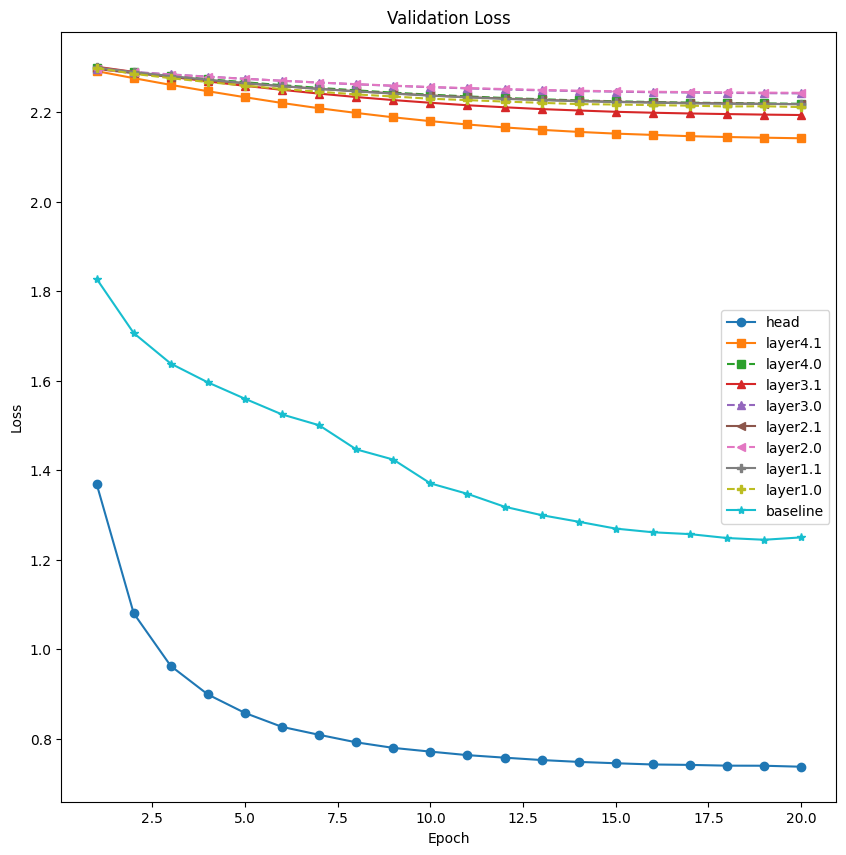

In [18]:
x = np.arange(1, N_EPOCHS+1, 1)
plt.figure(figsize=(10, 10))
markers = [
    "o-",
    "s-",
    "s--",
    "^-",
    "^--",
    "<-",
    "<--",
    "P-",
    "P--",
]
for s, m in zip(storage_list, markers):

    plt.plot(x, s.storage['val_loss'], m , label=s.name)

plt.plot(x, storage_baseline.storage['val_loss'], '*-', label=storage_baseline.name)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

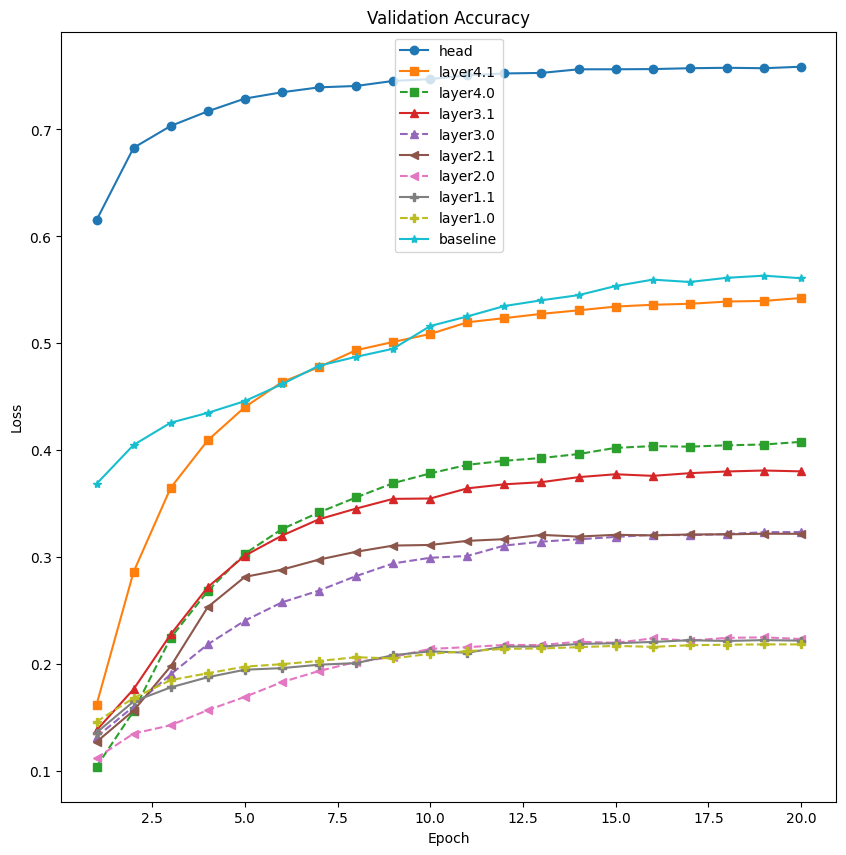

In [19]:
x = np.arange(1, N_EPOCHS+1, 1)
plt.figure(figsize=(10, 10)) 
markers = [
    "o-",
    "s-",
    "s--",
    "^-",
    "^--",
    "<-",
    "<--",
    "P-",
    "P--",
]
for s, m in zip(storage_list, markers):

    plt.plot(x, s.storage['val_accuracy'], m, label=s.name)

plt.plot(x, storage_baseline.storage['val_accuracy'], '*-', label=storage_baseline.name)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Accuracy')
plt.show()

In [20]:
dfs = []
for s in storage_list:
    df = pd.DataFrame(s.storage)
    df['name'] = s.name
    df = df.iloc[len(df)-1:]
    dfs.append(df)

perf_df = pd.concat(dfs).reset_index(drop=True)
perf_df

,train_loss,val_loss,train_accuracy,val_accuracy,name
0,0.724812,0.737345,0.76090,0.7587,head
1,2.143719,2.142116,0.54364,0.5424,layer4.1
2,2.220374,2.219267,0.40202,0.4079,layer4.0
3,2.196173,2.194095,0.37850,0.3803,layer3.1
4,2.243353,2.242412,0.32134,0.3236,layer3.0
5,2.219622,2.218465,0.32776,0.3219,layer2.1
6,2.244719,2.243793,0.22412,0.2235,layer2.0
7,2.220352,2.218239,0.21286,0.2220,layer1.1
8,2.216380,2.211900,0.21678,0.2185,layer1.0


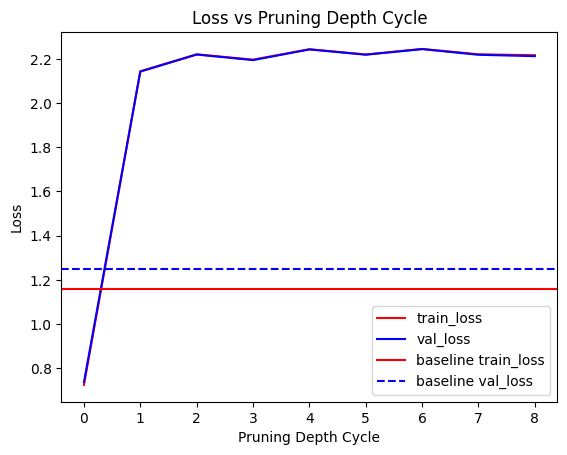

In [21]:
plt.plot(perf_df['train_loss'], 'r', label='train_loss')
plt.plot(perf_df['val_loss'], 'b', label='val_loss')
plt.axhline(y=storage_baseline.storage['train_loss'][-1], color='r', linestyle='-', label='baseline train_loss')
plt.axhline(y=storage_baseline.storage['val_loss'][-1], color='b', linestyle='--', label='baseline val_loss')

plt.xlabel('Pruning Depth Cycle')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Pruning Depth Cycle')
plt.show()


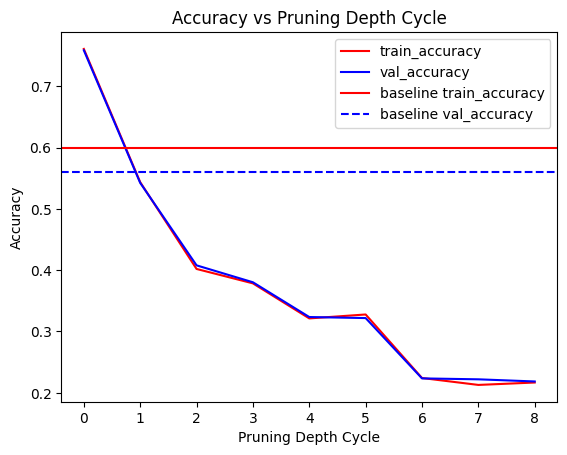

In [22]:
plt.plot(perf_df['train_accuracy'], 'r', label='train_accuracy')
plt.plot(perf_df['val_accuracy'], 'b', label='val_accuracy')
plt.axhline(y=storage_baseline.storage['train_accuracy'][-1], color='r', linestyle='-', label='baseline train_accuracy')
plt.axhline(y=storage_baseline.storage['val_accuracy'][-1], color='b', linestyle='--', label='baseline val_accuracy')

plt.xlabel('Pruning Depth Cycle')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Pruning Depth Cycle')
plt.show()

In [23]:
import os, sys
sys.exit()

SystemExit: 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
